In [5]:
stock_name = "^GSPC"
date_predict_start = '2020-01-01'
data_range = 250
slide_range = 10
n_slide = 10
pv_range = 7
n_harm_lower_limit = 1
n_harm_upper_limit = 50
fit_method = 'rmse'
pv_method = 'CL'

base_day = 10
prediction_day = base_day
slide = base_day

profit_percentage = 0.1
loss_percentage = 0.1

# Import packages


In [6]:
import numpy as np
import pylab as pl
from numpy import fft
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import datetime
from dateutil.relativedelta import relativedelta
import math
import matplotlib.dates as mdates
import warnings
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.callbacks import EarlyStopping
from tqdm import tqdm
import matplotlib.patches as patches

# Load data


In [7]:
def load_data(stock_name, date_predict_start, data_range, slide_range, n_slide):
    train_data = {}
    test_data = {}
    date_predict_start = datetime.datetime.strptime(
        date_predict_start, '%Y-%m-%d').date()
    date_data_start_list = []
    date_predict_start_list = []
    date_predict_end_list = []
    test_data_start_list = []
    all_data = yf.Ticker(stock_name).history(period='max')
    all_data.index = all_data.index.date
    check = date_predict_start in all_data.index
    while (check == False):
        date_predict_start = date_predict_start + \
            relativedelta(days=+1)
        check = date_predict_start in list(all_data.index)
    predict_start = all_data.index.get_loc(date_predict_start)
    for i in range(n_slide):
        predict_end = predict_start + data_range
        date_predict_end = all_data.iloc[predict_end].name
        data_start = predict_start - data_range
        date_data_start = all_data.iloc[data_start].name
        train_data['data_' + str(i)] = all_data.iloc[data_start:predict_start]
        test_data['data_' + str(i)] = all_data.iloc[predict_start:predict_end]
        date_data_start_list.append(date_data_start)
        date_predict_start_list.append(date_predict_start)
        date_predict_end_list.append(date_predict_end)
        test_data_start_list.append(test_data['data_' + str(i)].index[0])
        data_start = data_start + slide_range
        predict_start = predict_start + slide_range
        train_data['data_' + str(i)] = train_data['data_' +
                                                  str(i)].reset_index(drop=False)
        test_data['data_' + str(i)] = test_data['data_' +
                                                str(i)].reset_index(drop=False)

    return train_data, test_data, all_data, test_data_start_list


# Data preprocessing


In [8]:
def find_data_pv_CL_function(data, pv_range):
    pd.options.mode.chained_assignment = None
    for i in data:
        price = data[i]['Close']
        data[i]['peaks'] = pd.Series(dtype='float64')
        data[i]['valleys'] = pd.Series(dtype='float64')
        data[i]['pv'] = pd.Series(dtype='str')
        for idx in range(0, len(price)):
            if idx < pv_range:
                if price[idx] == price.iloc[0:pv_range*2+1].max():
                    data[i]['peaks'].iloc[idx] = price[idx]
                    data[i]['pv'].iloc[idx] = 'peak'
                if price[idx] == price.iloc[0:pv_range*2+1].min():
                    data[i]['valleys'].iloc[idx] = price[idx]
                    data[i]['pv'].iloc[idx] = 'valley'
            if price[idx] == price.iloc[idx-pv_range:idx+pv_range].max():
                data[i]['peaks'].iloc[idx] = price[idx]
                data[i]['pv'].iloc[idx] = 'peak'
            if price[idx] == price.iloc[idx-pv_range:idx+pv_range].min():
                data[i]['valleys'].iloc[idx] = price[idx]
                data[i]['pv'].iloc[idx] = 'valley'


In [9]:
def find_data_pv_HL_function(data, pv_range):
    pd.options.mode.chained_assignment = None
    for i in data:
        high = data[i]['High']
        low = data[i]['Low']
        data[i]['peaks'] = pd.Series(dtype='float64')
        data[i]['valleys'] = pd.Series(dtype='float64')
        data[i]['pv'] = pd.Series(dtype='str')
        for idx in range(0, len(high)):
            if idx < pv_range and idx>0:
                if high[idx] == high.iloc[0:pv_range*2+1].max():
                    data[i]['peaks'].iloc[idx] = high[idx]
                    data[i]['pv'].iloc[idx] = 'peak'
                if low[idx] == low.iloc[0:pv_range*2+1].min():
                    data[i]['valleys'].iloc[idx] = low[idx]
                    data[i]['pv'].iloc[idx] = 'valley'
            if high[idx] == high.iloc[idx-pv_range:idx+pv_range].max():
                data[i]['peaks'].iloc[idx] = high[idx]
                data[i]['pv'].iloc[idx] = 'peak'
            if low[idx] == low.iloc[idx-pv_range:idx+pv_range].min():
                data[i]['valleys'].iloc[idx] = low[idx]
                data[i]['pv'].iloc[idx] = 'valley'


In [10]:
def preprocessing(train_data, test_data, pv_range, pv_method):
    if pv_method == 'CL':
        find_data_pv_CL_function(train_data, pv_range)
        find_data_pv_CL_function(test_data, pv_range)
    elif pv_method == 'HL':
        find_data_pv_HL_function(train_data, pv_range)
        find_data_pv_HL_function(test_data, pv_range)
    else :
        print('worng pv_method')


# Built Model


Get signal


In [11]:
def data_to_harmonics_function(data_stock, data_range):
    harmonics = {}
    for i in data_stock:
        harmonics[i] = {}
        # get data_stock's infomation
        data = data_stock[i]['Close']
        array_data = np.array(data)
        n_data = array_data.size
        time_data = np.arange(0, n_data)

        # detrend data
        # find linear trend in data
        Polynomial = np.polyfit(time_data, array_data, 1)
        data_notrend = array_data - Polynomial[0] * time_data    # detrended x

        # fft process
        data_freqdom = fft.fft(data_notrend, n=n_data)
        frequence = fft.fftfreq(n=n_data, d=1)
        f_positive = frequence[np.where(frequence > 0)]
        data_freqdom_positive = data_freqdom[np.where(frequence > 0)]

        # sort indexes
        indexes = list(range(f_positive.size))      # frequencies
        # sort method 1
        # indexes.sort(key = lambda i: np.absolute(frequence[i]))     # sort indexes by frequency, lower -> higher
        # sort method 2 :
        # sort indexes by amplitudes, lower -> higher
        indexes.sort(key=lambda i: np.absolute(data_freqdom[i]))
        indexes.reverse()       # sort indexes by amplitudes, higher -> lower

        # get data_all_time'size
        time_transfer = np.arange(0, data_range*2)

        # get harmonics
        for j in indexes:
            ampli = np.absolute(
                data_freqdom_positive[j]) / n_data     # amplitude
            phase = np.angle(data_freqdom_positive[j])      # phase
            harmonics[i][j] = ampli * \
                np.cos(2 * np.pi * f_positive[j] * time_transfer + phase)
    return harmonics


In [12]:
def mix_harmonics_function(harmonics, n_harm_lower_limit, n_harm_upper_limit):
    processed_signal = {}
    for i in harmonics:
        processed_signal[i] = {}
        for n_harm in range(n_harm_lower_limit, n_harm_upper_limit+1):
            mixed_harmonic = np.zeros(len(harmonics[i][0]))
            # for j in range(n_harm):
            for j in range(2, n_harm):
                mixed_harmonic += harmonics[i][j]
            processed_signal[i][n_harm] = pd.DataFrame(
                {'Close': mixed_harmonic})
    return processed_signal


Signal processing


In [13]:
def find_signal_pv_function(signal, pv_range):
    pd.options.mode.chained_assignment = None
    for i in signal:
        for j in signal[i]:
            data = signal[i][j]['Close']
            signal[i][j]['peaks'] = pd.Series(dtype='float64')
            signal[i][j]['valleys'] = pd.Series(dtype='float64')
            signal[i][j]['pv'] = pd.Series(dtype='str')
            for idx in range(0, len(data)):
                if idx < pv_range and idx>0:
                    if data[idx] == data.iloc[0:pv_range*2+1].max():
                        signal[i][j]['peaks'].iloc[idx] = data[idx]
                        signal[i][j]['pv'].iloc[idx] = 'peak'
                    if data[idx] == data.iloc[0:pv_range*2+1].min():
                        signal[i][j]['valleys'].iloc[idx] = data[idx]
                        signal[i][j]['pv'].iloc[idx] = 'valley'
                if data[idx] == data.iloc[idx-pv_range:idx+pv_range].max():
                    signal[i][j]['peaks'].iloc[idx] = data[idx]
                    signal[i][j]['pv'].iloc[idx] = 'peak'
                if data[idx] == data.iloc[idx-pv_range:idx+pv_range].min():
                    signal[i][j]['valleys'].iloc[idx] = data[idx]
                    signal[i][j]['pv'].iloc[idx] = 'valley'


In [14]:
def find_signal_lead_train_function(data, processed_signal):
    for d in data:
        for p in processed_signal[d]:
            # processed_signal[d][p]['pv'] = pd.Series(dtype='str')
            processing_signal = processed_signal[d][p].head(len(data[d]))
            p_data = pd.DataFrame(
                {'peaks': data[d]['peaks'], 'count': range(len(data[d]))})
            p_data = p_data.drop(p_data[p_data['peaks'].isna()].index)
            p_data_count = list(p_data['count'])
            p_signal = pd.DataFrame(
                {'peaks': processing_signal['peaks'], 'count': range(len(processing_signal))})
            p_signal = p_signal.drop(p_signal[p_signal['peaks'].isna()].index)
            p_signal_list = list(p_signal['count'])
            p_lead = []
            for i in range(0, len(p_signal_list)):
                temp = []
                temp_abs = []
                temp_2 = []
                for j in range(0, len(p_data_count)):
                    temp.append((p_data_count[j] - p_signal_list[i]))
                    temp_abs.append(abs(p_data_count[j] - p_signal_list[i]))
                for k in range(0, len(temp_abs)):
                    if temp_abs[k] == min(temp_abs):
                        temp_2 = temp[k]
                p_lead.append(temp_2)
            p_signal['lead'] = p_lead

            v_data = pd.DataFrame(
                {'valleys': data[d]['valleys'], 'count': range(len(data[d]))})
            v_data = v_data.drop(v_data[v_data['valleys'].isna()].index)
            v_data_count = list(v_data['count'])
            v_signal = pd.DataFrame(
                {'valleys': processing_signal['valleys'], 'count': range(len(processing_signal))})
            v_signal = v_signal.drop(
                v_signal[v_signal['valleys'].isna()].index)
            v_signal_list = list(v_signal['count'])
            v_lead = []
            for i in range(0, len(v_signal_list)):
                temp = []
                temp_abs = []
                temp_2 = []
                for j in range(0, len(v_data_count)):
                    temp.append((v_data_count[j] - v_signal_list[i]))
                    temp_abs.append(abs(v_data_count[j] - v_signal_list[i]))
                for k in range(0, len(temp_abs)):
                    if temp_abs[k] == min(temp_abs):
                        temp_2 = temp[k]
                v_lead.append(temp_2)
            v_signal['lead'] = v_lead

            processed_signal[d][p]['lead'] = pd.Series(dtype='float64')
            processed_signal[d][p]['lead'].loc[p_signal['lead'].index] = p_signal['lead']
            processed_signal[d][p]['lead'].loc[v_signal['lead'].index] = v_signal['lead']


In [15]:
def build_model(train_data, n_harm_lower_limit, n_harm_upper_limit, pv_range, data_range):
    harmonics = data_to_harmonics_function(train_data, data_range)
    processed_signal = mix_harmonics_function(
        harmonics, n_harm_lower_limit, n_harm_upper_limit)
    find_signal_pv_function(processed_signal, pv_range)
    find_signal_lead_train_function(train_data, processed_signal)
    return harmonics, processed_signal


# Select model


In [16]:
def get_fit_error_function(processed_signal, fit_method):
    errors = {}
    error = []
    for i in processed_signal:
        errors[i] = {}
        for j in processed_signal[i]:
            signal_dropna = processed_signal[i][j].drop(
                processed_signal[i][j][processed_signal[i][j]['lead'].isna()].index)
            if fit_method == 'mean':
                error = signal_dropna['lead'].mean()
            elif fit_method == 'abs':
                error = abs(signal_dropna['lead']).mean()
            elif fit_method == 'rmse':
                mse = np.square(np.subtract(np.zeros_like(
                    signal_dropna['lead']), signal_dropna['lead'])).mean()
                rmse = math.sqrt(mse)
                error = rmse
            else :
                print('worng fit_method')
            errors[i][j] = error
    return errors


In [17]:
def get_best_fit_harm_function(processed_signal, errors):
    best_error = {}
    best_fit_harm = {}
    for i in processed_signal:
        best_error[i] = pd.Series(errors[i]).abs().min()
        best_fit_harm[i] = pd.Series(errors[i]).abs().idxmin()
    return best_fit_harm, best_error


In [18]:
def find_signal_lead_test_function(data, processed_signal):
    for d in data:
        for p in processed_signal[d]:
            processed_signal[d][p]['pv'] = pd.Series(dtype='str')
            processing_signal = processed_signal[d][p].tail(len(data[d]))
            p_data = pd.DataFrame(
                {'peaks': data[d]['peaks'], 'count': range(len(data[d]))})
            p_data = p_data.drop(p_data[p_data['peaks'].isna()].index)
            p_data_count = list(p_data['count'])
            p_signal = pd.DataFrame(
                {'peaks': processing_signal['peaks'], 'count': range(len(processing_signal))})
            p_signal = p_signal.drop(p_signal[p_signal['peaks'].isna()].index)
            p_signal_list = list(p_signal['count'])
            p_lead = []
            for i in range(0, len(p_signal_list)):
                temp = []
                temp_abs = []
                temp_2 = []
                for j in range(0, len(p_data_count)):
                    temp.append((p_data_count[j] - p_signal_list[i]))
                    temp_abs.append(abs(p_data_count[j] - p_signal_list[i]))
                for k in range(0, len(temp_abs)):
                    if temp_abs[k] == min(temp_abs):
                        temp_2 = temp[k]
                p_lead.append(temp_2)
            p_signal['lead'] = p_lead

            v_data = pd.DataFrame(
                {'valleys': data[d]['valleys'], 'count': range(len(data[d]))})
            v_data = v_data.drop(v_data[v_data['valleys'].isna()].index)
            v_data_count = list(v_data['count'])
            v_signal = pd.DataFrame(
                {'valleys': processing_signal['valleys'], 'count': range(len(processing_signal))})
            v_signal = v_signal.drop(
                v_signal[v_signal['valleys'].isna()].index)
            v_signal_list = list(v_signal['count'])
            v_lead = []
            for i in range(0, len(v_signal_list)):
                temp = []
                temp_abs = []
                temp_2 = []
                for j in range(0, len(v_data_count)):
                    temp.append((v_data_count[j] - v_signal_list[i]))
                    temp_abs.append(abs(v_data_count[j] - v_signal_list[i]))
                for k in range(0, len(temp_abs)):
                    if temp_abs[k] == min(temp_abs):
                        temp_2 = temp[k]
                v_lead.append(temp_2)
            v_signal['lead'] = v_lead

            processed_signal[d][p]['lead'] = pd.Series(dtype='float64')
            processed_signal[d][p]['lead'].loc[p_signal['lead'].index] = p_signal['lead']
            processed_signal[d][p]['pv'].loc[p_signal['lead'].index] = 'peak'
            processed_signal[d][p]['lead'].loc[v_signal['lead'].index] = v_signal['lead']
            processed_signal[d][p]['pv'].loc[v_signal['lead'].index] = 'valley'


In [19]:
def get_first_lead_function(processed_signal, best_fit_harm):
    first_date = {}
    lead = {}
    pv = {}
    for i in processed_signal:
        harm = best_fit_harm[i]
        temp = processed_signal[i][harm].loc[list(
            processed_signal[i][harm]['lead'].dropna().index)[0]]
        first_index = list(processed_signal[i][harm]
                             ['lead'].dropna().index)[0]
        first_date[i] = processed_signal[i][harm].index.get_loc(first_index)
        lead[i] = temp['lead']
        pv[i] = temp['pv']
    return first_date, lead, pv


In [20]:
def select_model(test_data, processed_signal, fit_method):
    errors = get_fit_error_function(processed_signal, fit_method)
    best_fit_harm, best_error = get_best_fit_harm_function(
        processed_signal, errors)
    find_signal_lead_test_function(test_data, processed_signal)
    first_date, lead, pv = get_first_lead_function(
        processed_signal, best_fit_harm)
    return errors, best_fit_harm, best_error, first_date, lead, pv


# Evaluate model


In [21]:
def built_result_table_function(processed_signal, test_data_start_list, lead, pv, best_error, best_fit_harm):
    result_table = pd.DataFrame(columns=[
        's_date', 't_date', 'lead', 'ans_date', 'pv', 'error', 'best_fit'])
    for i in processed_signal:
        result_table.loc[i, 'error'] = round(best_error[i], 2)
        result_table.loc[i, 'best_fit'] = best_fit_harm[i]
        result_table.loc[i, 'lead'] = lead[i]
        result_table.loc[i, 'pv'] = pv[i]
    result_table['s_date'] = test_data_start_list
    return result_table


In [22]:
def result_table_process_function(result_table, all_data, first_date, data_range):
    for i in result_table.index:
        t_date = all_data.iloc[all_data.index.get_loc(result_table.loc[i, 's_date']) + first_date[i] - data_range].name
        result_table.loc[i, 't_date'] = t_date
        ans = all_data.iloc[int(all_data.index.get_loc(t_date) + result_table.loc[i, 'lead'])].name
        result_table.loc[i, 'ans_date'] = ans

In [23]:
def compute_final_error_function(result_table):
    final_error = round(
        sum([abs(ele) for ele in result_table['lead']]) / len(result_table['lead']), 2)
    return final_error


In [24]:
def evaluate_model(processed_signal, test_data_start_list, all_data, best_fit_harm, best_error, first_date, lead, pv, data_range):
    result_table = built_result_table_function(
        processed_signal, test_data_start_list, lead, pv, best_error, best_fit_harm)
    result_table_process_function(
        result_table, all_data, first_date, data_range)
    final_error = compute_final_error_function(result_table)
    return result_table, final_error


# Draw plot


In [25]:
def find_data_pv_function(data, pv_range):
    pd.options.mode.chained_assignment = None
    price = data['Close']
    data['peaks'] = pd.Series(dtype='float64')
    data['valleys'] = pd.Series(dtype='float64')
    data['pv'] = pd.Series(dtype='str')
    for idx in range(0, len(price)):
        if idx < pv_range and idx>0:
            if price[idx] == price.iloc[0:pv_range*2+1].max():
                data['peaks'].iloc[idx] = price[idx]
                data['pv'].iloc[idx] = 'peak'
            if price[idx] == price.iloc[0:pv_range*2+1].min():
                data['valleys'].iloc[idx] = price[idx]
                data['pv'].iloc[idx] = 'valleys'
        if price[idx] == price.iloc[idx-pv_range:idx+pv_range].max():
            data['peaks'].iloc[idx] = price[idx]
            data['pv'].iloc[idx] = 'peak'
        if price[idx] == price.iloc[idx-pv_range:idx+pv_range].min():
            data['valleys'].iloc[idx] = price[idx]
            data['pv'].iloc[idx] = 'valleys'


In [26]:
def draw_plot_result_table(test_data, all_data, result_table, pv_range):
    date_list = sorted(
        list(result_table['s_date']) + list(result_table['t_date']) + list(result_table['ans_date']))
    all_index = all_data.loc[date_list[0]:date_list[-1]].index
    fig, axes = plt.subplots(2, 1, figsize=(30, 8), sharex=True)
    test_data_copy = test_data.copy()
    for d in test_data :
        test_data_copy[d].index = test_data[d]['index']
        test_data_copy[d] = test_data_copy[d].drop(test_data_copy[d][test_data_copy[d].index > date_list[-1]].index)
        axes[0].plot(test_data_copy[d].index, test_data_copy[d]['Close'], 'gray', label='data', linewidth=3)
    for d in test_data_copy :
        axes[0].plot(test_data_copy[d].index, test_data_copy[d]['peaks'],
                    '^', c='royalblue', label='peaks')
        axes[0].plot(test_data_copy[d].index, test_data_copy[d]['valleys'], 'v',
                    c='orangered', label='valleys')
    plot_model = pd.DataFrame(index=all_index, columns=[
                                's_date', 't_date', 'ans_date', 'lead', 'pv'])
    plot_model['s_date'].loc[result_table['s_date']] = True
    plot_model['t_date'].loc[result_table['t_date']] = True
    plot_model['lead'].loc[result_table['t_date']] = list(result_table['lead'])
    plot_model['pv'].loc[result_table['t_date']] = list(result_table['pv'])
    plot_model['ans_date'].loc[result_table['ans_date']] = True
    for i, label in enumerate(plot_model['lead']):
        if plot_model['pv'][i] == 'peak':
            # axes[0].plot(plot_data.index[i], plot_data['Close'].iloc[i], '|',
            #             c='red')
            axes[1].plot(plot_model.index[i], plot_model['lead'][i], '^',
                            c='royalblue')
            text = str(label)
            axes[1].annotate(text, (plot_model.index[i],
                                plot_model['lead'][i]), fontsize=14)
        elif plot_model['pv'][i] == 'valley':
            # axes[0].plot(plot_data.index[i], plot_data['Close'].iloc[i], '|',
            #             c='red')
            axes[1].plot(plot_model.index[i], plot_model['lead'][i], 'v',
                            c='orangered')
            text = str(label)
            axes[1].annotate(text, (plot_model.index[i],
                                plot_model['lead'][i]), fontsize=14)

    axes[0].set_ylabel("Stock price", fontsize=14)
    axes[0].grid(True)
    axes[1].grid(True)
    axes[1].set_ylabel("lead", fontsize=14)
    plt.show()

# Main function


In [27]:
def main_funtion(
    stock_name, date_predict_start, data_range, slide_range,
        n_slide, pv_range, n_harm_lower_limit, n_harm_upper_limit, fit_method, pv_method):

    # 1. Load data
    train_data, test_data, all_data, test_data_start_list = load_data(
        stock_name, date_predict_start, data_range, slide_range, n_slide)
    # 2. Preprocessing
    preprocessing(train_data, test_data, pv_range, pv_method)
    # 3. Build model
    harmonics, model = build_model(
        train_data, n_harm_lower_limit, n_harm_upper_limit, pv_range, data_range)
    # 4. Select model
    errors, best_fit_harm, best_error, first_date, lead, pv = select_model(test_data,
                                                                           model, fit_method)
    # 5. Evaluate model
    result_table, final_error = evaluate_model(
        model, test_data_start_list, all_data, best_fit_harm, best_error, first_date, lead, pv, data_range)
    print('final_error = ', final_error)
    with pd.option_context('display.max_rows', None,
                       'display.max_columns', None,
                       'display.precision', 3,
                       ):
        print(result_table)
    draw_plot_result_table(test_data, all_data, result_table, pv_range)
    # return harmonics, model, errors, best_fit_harm, best_error, first_date, lead, pv, result_table, final_error


In [28]:
# main_funtion(
#     stock_name, date_predict_start, data_range, slide_range,
#         n_slide, pv_range, n_harm_lower_limit, n_harm_upper_limit, fit_method, pv_method)

# Lstm function

In [29]:
def preprocessing_train_data_Lstm(train_data, base_day, prediction_day, slide):
    x_train = {}
    y_train = {}
    for i in train_data:
        scaler = MinMaxScaler(feature_range=(-1,1))
        scaled_data = scaler.fit_transform(train_data[i]['Close'].values.reshape(-1,1))
        x_train[i] = []
        y_train[i] = []
        # for x in range(base_day+prediction_day, len(scaled_data), slide):
        for x in range(base_day+prediction_day, len(scaled_data)):
            x_train[i].append(scaled_data[x-base_day-prediction_day:x-prediction_day])
            y_train[i].append(scaled_data[x-prediction_day:x])
        x_train[i], y_train[i] = np.array(x_train[i]), np.array(y_train[i])
        # 將x_train數組的形狀轉換為（樣本數，天數，特徵數）的形式，這裡的特徵數為1
        x_train[i] = np.reshape(x_train[i], (x_train[i].shape[0], x_train[i].shape[1], 1))
        y_train[i] = np.reshape(y_train[i], (y_train[i].shape[0], y_train[i].shape[1], 1))
    return x_train, y_train

In [30]:
def LSTM_model(prediction_day, input_shape):
    model = Sequential()
    model.add(LSTM(units = 256, return_sequences = True, input_shape = input_shape))
    model.add(Dropout(0.4))
    model.add(LSTM(units = 128, return_sequences = True))
    model.add(Dropout(0.4))
    model.add(LSTM(units = 64))
    model.add(Dropout(0.4))
    model.add(Dense(units=prediction_day))
    return model

In [31]:
def build_Lstm_model(train_data, prediction_day, input_shape):
    model = {}
    for i in train_data:
        model[i] = LSTM_model(prediction_day, input_shape)
        model[i].compile(optimizer='adam', 
                    loss='mean_squared_error')
        # model[i].summary()
    return model

In [32]:
def train_Lstm_model(train_data, model, x_train, y_train):
    history = {}
    for i in tqdm(train_data):
        earlystopper = EarlyStopping(monitor = 'val_loss', patience = 5, verbose = 2)
        history[i] = model[i].fit(x_train[i], y_train[i], epochs=25, batch_size=32, 
                            callbacks = [earlystopper], validation_split = 0.2, shuffle=True)
    return history

In [33]:
def preprocessing_test_data_Lstm(train_data, test_data, base_day, prediction_day, slide):
    x_test = {}
    y_test = {}
    for i in test_data:
        scaler = MinMaxScaler(feature_range=(-1,1))
        model_inputs = pd.concat((train_data[i]['Close'].iloc[-base_day:], test_data[i]['Close'])).values
        model_inputs = model_inputs.reshape(-1,1)
        model_inputs = scaler.fit_transform(model_inputs)
        x_test[i] = []
        y_test[i] = []
        for x in range(base_day+prediction_day, len(model_inputs), slide):
            x_test[i].append(model_inputs[x-base_day-prediction_day:x-prediction_day])
            y_test[i].append(model_inputs[x-prediction_day:x])
        x_test[i], y_test[i] = np.array(x_test[i]), np.array(y_test[i])
        x_test[i] = np.reshape(x_test[i], (x_test[i].shape[0], x_test[i].shape[1], 1))
        y_test[i] = np.reshape(y_test[i], (y_test[i].shape[0], y_test[i].shape[1], 1))
    return x_test, y_test

In [34]:
def predicting_creat_processed_signal_Lstm(x_test, test_data, model):
    processed_signal = {}
    for i in test_data:
        predicted_prices = model[i].predict(x_test[i])
        processed_signal[i] = {}
        processed_signal[i][0] = pd.DataFrame(
            {'Close': predicted_prices.flatten()}, index=test_data[i].index[:len(predicted_prices.flatten())])
    return processed_signal

In [35]:
def result_table_process_Lstm_function(result_table, all_data, first_date, data_range):
    for i in result_table.index:
        t_date = all_data.iloc[int(all_data.index.get_loc(result_table.loc[i, 's_date'])) + first_date[i]].name
        result_table.loc[i, 't_date'] = t_date
        ans = all_data.iloc[int(all_data.index.get_loc(t_date) + result_table.loc[i, 'lead'])].name
        result_table.loc[i, 'ans_date'] = ans

In [36]:
# 1. Load data
train_data, test_data, all_data, test_data_start_list = load_data(
    stock_name, date_predict_start, data_range, slide_range, n_slide)
# 2. Preprocessing
preprocessing(train_data, test_data, pv_range, pv_method)
x_train, y_train = preprocessing_train_data_Lstm(train_data, base_day, prediction_day, slide)
x_test, y_test = preprocessing_test_data_Lstm(train_data, test_data, base_day, prediction_day, slide)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/25
6/6 [==============================] - 7s 314ms/step - loss: 0.0554 - val_loss: 0.2510
Epoch 2/25
6/6 [==============================] - 0s 64ms/step - loss: 0.0330 - val_loss: 0.1088
Epoch 3/25
6/6 [==============================] - 0s 58ms/step - loss: 0.0270 - val_loss: 0.1914
Epoch 4/25
6/6 [==============================] - 0s 57ms/step - loss: 0.0259 - val_loss: 0.1753
Epoch 5/25
6/6 [==============================] - 0s 58ms/step - loss: 0.0265 - val_loss: 0.1612
Epoch 6/25
6/6 [==============================] - 0s 60ms/step - loss: 0.0260 - val_loss: 0.1534
Epoch 7/25
6/6 [==============================] - 0s 58ms/step - loss: 0.0242 - val_loss: 0.1753
Epoch 7: early stopping


 10%|█         | 1/10 [00:09<01:23,  9.33s/it]

Epoch 1/25
6/6 [==============================] - 8s 316ms/step - loss: 0.0690 - val_loss: 0.2488
Epoch 2/25
6/6 [==============================] - 0s 62ms/step - loss: 0.0435 - val_loss: 0.2315
Epoch 3/25
6/6 [==============================] - 0s 58ms/step - loss: 0.0376 - val_loss: 0.1700
Epoch 4/25
6/6 [==============================] - 0s 55ms/step - loss: 0.0358 - val_loss: 0.1769
Epoch 5/25
6/6 [==============================] - 0s 59ms/step - loss: 0.0330 - val_loss: 0.1897
Epoch 6/25
6/6 [==============================] - 0s 57ms/step - loss: 0.0319 - val_loss: 0.2092
Epoch 7/25
6/6 [==============================] - 0s 62ms/step - loss: 0.0325 - val_loss: 0.2081
Epoch 8/25
6/6 [==============================] - 0s 58ms/step - loss: 0.0303 - val_loss: 0.2060
Epoch 8: early stopping


 20%|██        | 2/10 [00:19<01:19,  9.89s/it]

Epoch 1/25
6/6 [==============================] - 7s 354ms/step - loss: 0.1210 - val_loss: 0.2560
Epoch 2/25
6/6 [==============================] - 0s 62ms/step - loss: 0.0598 - val_loss: 0.2531
Epoch 3/25
6/6 [==============================] - 0s 54ms/step - loss: 0.0554 - val_loss: 0.2101
Epoch 4/25
6/6 [==============================] - 0s 55ms/step - loss: 0.0455 - val_loss: 0.2048
Epoch 5/25
6/6 [==============================] - 0s 54ms/step - loss: 0.0470 - val_loss: 0.1853
Epoch 6/25
6/6 [==============================] - 0s 54ms/step - loss: 0.0444 - val_loss: 0.1778
Epoch 7/25
6/6 [==============================] - 0s 55ms/step - loss: 0.0444 - val_loss: 0.1900
Epoch 8/25
6/6 [==============================] - 0s 55ms/step - loss: 0.0437 - val_loss: 0.1904
Epoch 9/25
6/6 [==============================] - 0s 54ms/step - loss: 0.0416 - val_loss: 0.1963
Epoch 10/25
6/6 [==============================] - 0s 54ms/step - loss: 0.0393 - val_loss: 0.1735
Epoch 11/25
6/6 [===========

 30%|███       | 3/10 [00:31<01:15, 10.81s/it]

Epoch 1/25
6/6 [==============================] - 7s 294ms/step - loss: 0.1677 - val_loss: 0.2253
Epoch 2/25
6/6 [==============================] - 0s 58ms/step - loss: 0.0752 - val_loss: 0.2070
Epoch 3/25
6/6 [==============================] - 0s 57ms/step - loss: 0.0681 - val_loss: 0.1756
Epoch 4/25
6/6 [==============================] - 0s 54ms/step - loss: 0.0591 - val_loss: 0.1455
Epoch 5/25
6/6 [==============================] - 0s 56ms/step - loss: 0.0532 - val_loss: 0.1375
Epoch 6/25
6/6 [==============================] - 0s 54ms/step - loss: 0.0531 - val_loss: 0.0986
Epoch 7/25
6/6 [==============================] - 0s 65ms/step - loss: 0.0512 - val_loss: 0.1013
Epoch 8/25
6/6 [==============================] - 0s 55ms/step - loss: 0.0477 - val_loss: 0.0750
Epoch 9/25
6/6 [==============================] - 0s 55ms/step - loss: 0.0475 - val_loss: 0.0832
Epoch 10/25
6/6 [==============================] - 0s 55ms/step - loss: 0.0475 - val_loss: 0.0606
Epoch 11/25
6/6 [===========

 40%|████      | 4/10 [00:46<01:14, 12.45s/it]

Epoch 1/25
6/6 [==============================] - 7s 341ms/step - loss: 0.1377 - val_loss: 0.3152
Epoch 2/25
6/6 [==============================] - 0s 61ms/step - loss: 0.0674 - val_loss: 0.2746
Epoch 3/25
6/6 [==============================] - 0s 55ms/step - loss: 0.0621 - val_loss: 0.2070
Epoch 4/25
6/6 [==============================] - 0s 58ms/step - loss: 0.0516 - val_loss: 0.1521
Epoch 5/25
6/6 [==============================] - 0s 76ms/step - loss: 0.0488 - val_loss: 0.1313
Epoch 6/25
6/6 [==============================] - 0s 61ms/step - loss: 0.0523 - val_loss: 0.0790
Epoch 7/25
6/6 [==============================] - 0s 61ms/step - loss: 0.0465 - val_loss: 0.0623
Epoch 8/25
6/6 [==============================] - 0s 61ms/step - loss: 0.0435 - val_loss: 0.0640
Epoch 9/25
6/6 [==============================] - 0s 54ms/step - loss: 0.0438 - val_loss: 0.0429
Epoch 10/25
6/6 [==============================] - 0s 55ms/step - loss: 0.0426 - val_loss: 0.0420
Epoch 11/25
6/6 [===========

 50%|█████     | 5/10 [00:58<01:01, 12.39s/it]

Epoch 1/25
6/6 [==============================] - 7s 296ms/step - loss: 0.0529 - val_loss: 0.1854
Epoch 2/25
6/6 [==============================] - 0s 61ms/step - loss: 0.0304 - val_loss: 0.1160
Epoch 3/25
6/6 [==============================] - 0s 57ms/step - loss: 0.0257 - val_loss: 0.1450
Epoch 4/25
6/6 [==============================] - 0s 62ms/step - loss: 0.0236 - val_loss: 0.1606
Epoch 5/25
6/6 [==============================] - 0s 61ms/step - loss: 0.0227 - val_loss: 0.2983
Epoch 6/25
6/6 [==============================] - 0s 60ms/step - loss: 0.0201 - val_loss: 0.2785
Epoch 7/25
6/6 [==============================] - 0s 65ms/step - loss: 0.0188 - val_loss: 0.3180
Epoch 7: early stopping


 60%|██████    | 6/10 [01:07<00:44, 11.23s/it]

Epoch 1/25
6/6 [==============================] - 7s 298ms/step - loss: 0.1069 - val_loss: 0.2879
Epoch 2/25
6/6 [==============================] - 0s 62ms/step - loss: 0.0477 - val_loss: 0.2583
Epoch 3/25
6/6 [==============================] - 0s 57ms/step - loss: 0.0444 - val_loss: 0.2490
Epoch 4/25
6/6 [==============================] - 0s 60ms/step - loss: 0.0338 - val_loss: 0.2755
Epoch 5/25
6/6 [==============================] - 0s 61ms/step - loss: 0.0278 - val_loss: 0.2469
Epoch 6/25
6/6 [==============================] - 0s 58ms/step - loss: 0.0278 - val_loss: 0.2883
Epoch 7/25
6/6 [==============================] - 0s 56ms/step - loss: 0.0242 - val_loss: 0.2712
Epoch 8/25
6/6 [==============================] - 0s 55ms/step - loss: 0.0235 - val_loss: 0.3049
Epoch 9/25
6/6 [==============================] - 0s 55ms/step - loss: 0.0208 - val_loss: 0.2775
Epoch 10/25
6/6 [==============================] - 0s 59ms/step - loss: 0.0221 - val_loss: 0.2686
Epoch 10: early stopping


 70%|███████   | 7/10 [01:17<00:32, 10.77s/it]

Epoch 1/25
6/6 [==============================] - 7s 343ms/step - loss: 0.1359 - val_loss: 0.3463
Epoch 2/25
6/6 [==============================] - 0s 60ms/step - loss: 0.0560 - val_loss: 0.3016
Epoch 3/25
6/6 [==============================] - 0s 56ms/step - loss: 0.0449 - val_loss: 0.3273
Epoch 4/25
6/6 [==============================] - 0s 55ms/step - loss: 0.0347 - val_loss: 0.3283
Epoch 5/25
6/6 [==============================] - 0s 57ms/step - loss: 0.0285 - val_loss: 0.3647
Epoch 6/25
6/6 [==============================] - 0s 55ms/step - loss: 0.0302 - val_loss: 0.3170
Epoch 7/25
6/6 [==============================] - 0s 55ms/step - loss: 0.0267 - val_loss: 0.3834
Epoch 7: early stopping


 80%|████████  | 8/10 [01:26<00:20, 10.10s/it]

Epoch 1/25
6/6 [==============================] - 6s 295ms/step - loss: 0.1631 - val_loss: 0.3238
Epoch 2/25
6/6 [==============================] - 0s 58ms/step - loss: 0.0639 - val_loss: 0.3082
Epoch 3/25
6/6 [==============================] - 0s 56ms/step - loss: 0.0456 - val_loss: 0.3493
Epoch 4/25
6/6 [==============================] - 0s 55ms/step - loss: 0.0390 - val_loss: 0.3473
Epoch 5/25
6/6 [==============================] - 0s 55ms/step - loss: 0.0328 - val_loss: 0.3515
Epoch 6/25
6/6 [==============================] - 0s 54ms/step - loss: 0.0309 - val_loss: 0.3684
Epoch 7/25
6/6 [==============================] - 0s 55ms/step - loss: 0.0285 - val_loss: 0.3253
Epoch 7: early stopping


 90%|█████████ | 9/10 [01:34<00:09,  9.59s/it]

Epoch 1/25
6/6 [==============================] - 6s 297ms/step - loss: 0.1929 - val_loss: 0.2686
Epoch 2/25
6/6 [==============================] - 0s 58ms/step - loss: 0.0773 - val_loss: 0.2943
Epoch 3/25
6/6 [==============================] - 0s 56ms/step - loss: 0.0543 - val_loss: 0.2988
Epoch 4/25
6/6 [==============================] - 0s 55ms/step - loss: 0.0450 - val_loss: 0.3628
Epoch 5/25
6/6 [==============================] - 0s 59ms/step - loss: 0.0402 - val_loss: 0.2988
Epoch 6/25
6/6 [==============================] - 0s 59ms/step - loss: 0.0368 - val_loss: 0.3522
Epoch 6: early stopping


100%|██████████| 10/10 [01:42<00:00, 10.29s/it]


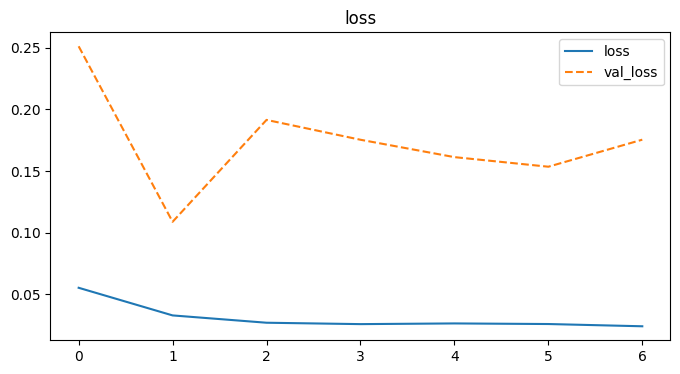

In [37]:
# 3. Build model
# harmonics, model = build_model(
    # train_data, n_harm_lower_limit, n_harm_upper_limit, pv_range, data_range)
# harmonics = data_to_harmonics_function(train_data, data_range)
# processed_signal_FFT = mix_harmonics_function(
#     harmonics, n_harm_lower_limit, n_harm_upper_limit)
# processed_signal = processed_signal_FFT

input_shape = (x_train[list(x_train.keys())[0]].shape[1],1)
model = build_Lstm_model(train_data, prediction_day, input_shape)

history = train_Lstm_model(train_data, model, x_train, y_train)
# Loss
fig, ax = plt.subplots(figsize=(8,4))
plt.title('loss')
plt.plot(history['data_0'].history['loss'], label='loss')
plt.plot(history['data_0'].history['val_loss'], label='val_loss', linestyle='--')
plt.legend()
plt.show()


In [38]:
processed_signal = predicting_creat_processed_signal_Lstm(x_test, test_data, model)
find_signal_pv_function(processed_signal, pv_range)
find_signal_lead_train_function(train_data, processed_signal)

1/1 [==============================] - 1s 1s/step


In [39]:
# 4. Select model
# errors, best_fit_harm, best_error, first_date, lead, pv = select_model(test_data,
#                                                                         model, fit_method)
errors = get_fit_error_function(processed_signal, fit_method)
best_fit_harm, best_error = get_best_fit_harm_function(
    processed_signal, errors)
find_signal_lead_test_function(test_data, processed_signal)
first_date, lead, pv = get_first_lead_function(
    processed_signal, best_fit_harm)


In [40]:
# 5. Evaluate model
# result_table, final_error = evaluate_model(
#     model, test_data_start_list, all_data, best_fit_harm, best_error, first_date, lead, pv, data_range)
result_table = built_result_table_function(
    processed_signal, test_data_start_list, lead, pv, best_error, best_fit_harm)
result_table_process_Lstm_function(
    result_table, all_data, first_date, data_range)
final_error = compute_final_error_function(result_table)
print('final_error = ', final_error)
with pd.option_context('display.max_rows', None,
                    'display.max_columns', None,
                    'display.precision', 3,
                    ):
    print(result_table)

final_error =  5.6
            s_date      t_date  lead    ans_date      pv  error best_fit
data_0  2020-01-02  2020-01-14  -7.0  2020-01-03  valley  10.52        0
data_1  2020-01-16  2020-01-29   2.0  2020-01-31  valley  11.14        0
data_2  2020-01-31  2020-02-13  -9.0  2020-01-31  valley  10.57        0
data_3  2020-02-14  2020-02-18   1.0  2020-02-19    peak  10.11        0
data_4  2020-03-02  2020-03-12  -6.0  2020-03-04    peak  10.05        0
data_5  2020-03-16  2020-03-26   0.0  2020-03-26    peak  11.78        0
data_6  2020-03-30  2020-04-08  -5.0  2020-04-01  valley  10.79        0
data_7  2020-04-14  2020-04-23  -2.0  2020-04-21  valley    9.6        0
data_8  2020-04-28  2020-05-08  20.0  2020-06-08    peak  10.41        0
data_9  2020-05-12  2020-05-19  -4.0  2020-05-13  valley   8.65        0


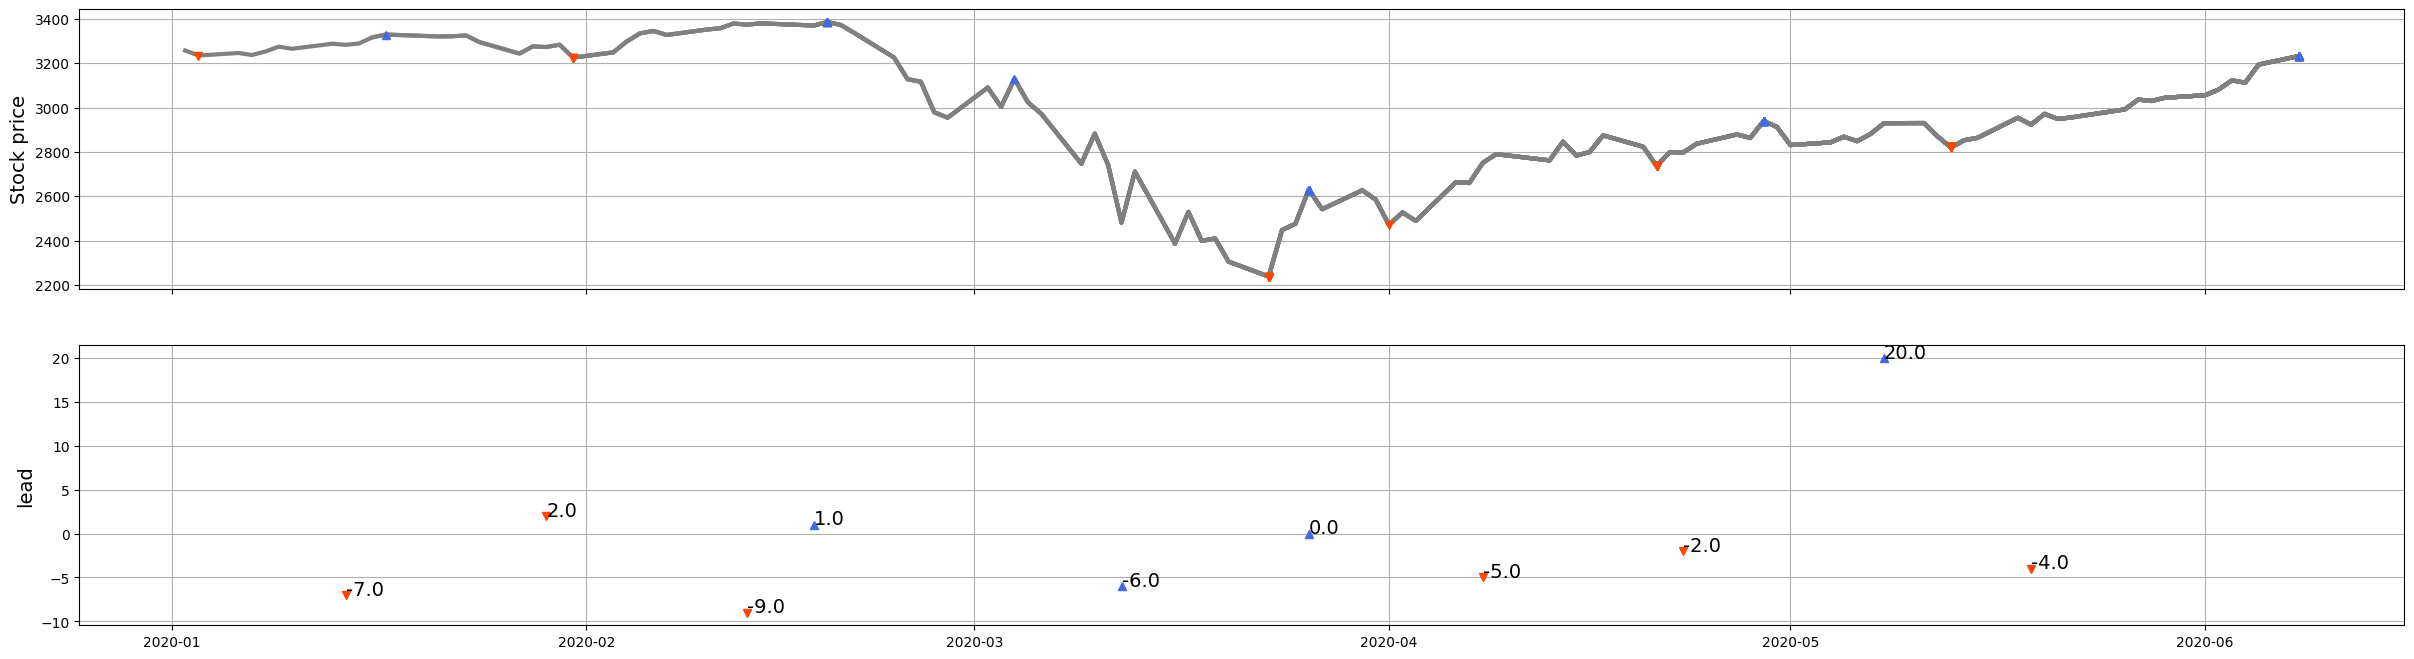

In [41]:
draw_plot_result_table(test_data, all_data, result_table, pv_range)

In [42]:
# for i in processed_signal:
#     fig, axes = plt.subplots(2, 1, figsize=(20, 8), sharex=True)
#     axes[0].set_title(i, fontsize=40)
#     axes[0].plot(range(0, len(train_data[i])), train_data[i]['Close'])
#     axes[0].plot(range(0, len(train_data[i])), train_data[i]['peaks'], '^')
#     axes[0].plot(range(0, len(train_data[i])), train_data[i]['valleys'], 'v')
#     axes[0].plot(range(len(train_data[i]), len(test_data[i])+len(train_data[i])), test_data[i]['Close'])
#     axes[0].plot(range(len(train_data[i]), len(test_data[i])+len(train_data[i])), test_data[i]['peaks'], '^')
#     axes[0].plot(range(len(train_data[i]), len(test_data[i])+len(train_data[i])), test_data[i]['valleys'], 'v')
#     axes[1].plot(range(len(train_data[i]), len(train_data[i])+len(processed_signal[i][best_fit_harm[i]])), processed_signal[i][best_fit_harm[i]]['Close'])
#     axes[1].plot(range(len(train_data[i]), len(train_data[i])+len(processed_signal[i][best_fit_harm[i]])), processed_signal[i][best_fit_harm[i]]['peaks'], '^')
#     axes[1].plot(range(len(train_data[i]), len(train_data[i])+len(processed_signal[i][best_fit_harm[i]])), processed_signal[i][best_fit_harm[i]]['valleys'], 'v')
#     plt.xlim(len(train_data[i]), len(train_data[i])+len(processed_signal[i][best_fit_harm[i]]))
#     axes[0].grid()
#     axes[1].grid()
#     plt.xticks(np.arange(len(train_data[i]), len(train_data[i])+len(processed_signal[i][best_fit_harm[i]]), step=10))
#     plt.show()

In [43]:
def kbar(open, close, high, low, pos, ax):
    if close > open:             # 上漲
        color='green'                 # 紅 K 棒
        height=close - open   # 高度=收盤-開盤
        bottom=open             # 底部=開盤
    else:                               # 下跌
        color='red'              # 綠 k 棒
        height=open - close   # 高度=開盤-收盤
        bottom=close             # 底部=收盤
    # 繪製 k 棒實體      
    ax.bar(pos, height=height,bottom=bottom, width=1, color=color)
    # 繪製 k 棒上下影線
    ax.vlines(pos, high, low, color=color)

In [44]:
def draw_profit_plot(profit_table, pv_range):
    date_list = sorted(
        list(profit_table['in_date']) + list(profit_table['out_date']))
    plot_data = all_data.loc[date_list[0]:date_list[-1]]
    find_data_pv_function(plot_data, pv_range)
    fig, ax = plt.subplots(figsize=(20, 8))
    # plt.subplots(figsize=(20, 8))
    for i in plot_data.index:
        kbar(plot_data['Open'].loc[i], plot_data['Close'].loc[i], plot_data['High'].loc[i], plot_data['Low'].loc[i], i, ax)
    # ax.plot(plot_data['peaks'], '^', label='peaks', c='royalblue')
    # ax.plot(plot_data['valleys'], 'v', label='valleys', c='orangered')
    for i in profit_table.index:
        if profit_table.loc[i, 'pv'] == 'peak':
            arrow = patches.FancyArrowPatch((profit_table.loc[i, 'in_date'], profit_table.loc[i, 'in_price']), (profit_table.loc[i, 'out_date'], profit_table.loc[i, 'out_price']), 
                                            linestyle='--', mutation_scale=20, arrowstyle='->', edgecolor='red')
            ax.add_patch(arrow)
            ax.plot(profit_table.loc[i, 'in_date'], plot_data['High'].loc[profit_table.loc[i, 'in_date']]+10, 'v', color='red')
            ax.plot(profit_table.loc[i, 'out_date'], plot_data['Low'].loc[profit_table.loc[i, 'out_date']]-10, '^', color='green')

        elif profit_table.loc[i, 'pv'] == 'valley':
            arrow = patches.FancyArrowPatch((profit_table.loc[i, 'in_date'], profit_table.loc[i, 'in_price']), (profit_table.loc[i, 'out_date'], profit_table.loc[i, 'out_price']), 
                                linestyle='--', mutation_scale=20, arrowstyle='->', edgecolor='green')
            ax.add_patch(arrow)
            ax.plot(profit_table.loc[i, 'in_date'], plot_data['Low'].loc[profit_table.loc[i, 'in_date']]-10, '^', color='green')
            ax.plot(profit_table.loc[i, 'out_date'], plot_data['High'].loc[profit_table.loc[i, 'out_date']]+10, 'v', color='red')
            
        if 'strategy' in profit_table.columns:
            if profit_table.loc[i, 'strategy'] == 'stop_profit':
                ax.hlines(profit_table.loc[i, 'strategy_price'], profit_table.loc[i, 'in_date'], profit_table.loc[i, 'out_date'], color='green', linestyles='dotted')
            elif profit_table.loc[i, 'strategy'] == 'stop_loss':
                ax.hlines(profit_table.loc[i, 'strategy_price'], profit_table.loc[i, 'in_date'], profit_table.loc[i, 'out_date'], color='red', linestyles='dotted')
            
    # ax.annotate(f'{i}', (profit_table.loc[i, 'in_date'], profit_table.loc[i, 'in_price']-100), fontsize=14, c='black')
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=5))
    plt.grid()
    # plt.legend()
    plt.show()

In [45]:
def build_profit_table_method_1(result_table):
    profit_table = pd.DataFrame(columns=['in_date', 'in_price', 'out_date', 'out_price', 'pv', 'profit'])
    total_profit = 0
    for i in result_table.index:
        in_price = all_data['Open'].iloc[all_data.index.get_loc(result_table.loc[i, 't_date'])]
        out_price = all_data['Close'].iloc[all_data.index.get_loc(result_table.loc[i, 't_date'])+pv_range]
        if result_table.loc[i, 'pv'] == 'valley':
            profit = out_price - in_price
            profit_table.loc[i, 'pv'] = 'valley'
        else:
            profit = in_price - out_price
            profit_table.loc[i, 'pv'] = 'peak'
        profit_table.loc[i, 'in_date'] = result_table.loc[i, 't_date']
        profit_table.loc[i, 'in_price'] = in_price
        profit_table.loc[i, 'out_date'] = all_data.iloc[all_data.index.get_loc(result_table.loc[i, 't_date'])+pv_range].name
        profit_table.loc[i, 'out_price'] = out_price
        profit_table.loc[i, 'profit'] = profit
        total_profit += profit
    return total_profit, profit_table

In [46]:
def build_profit_table_method_2(result_table, profit_percentage, loss_percentage):
    '''percentage:fioat
    '''
    profit_table = pd.DataFrame(columns=['in_date', 'in_price', 'out_date', 'out_price', 'pv', 'profit', 'strategy', 'strategy_price'])
    total_profit = 0
    for i in result_table.index:
        in_price = all_data['Open'].iloc[all_data.index.get_loc(result_table.loc[i, 't_date'])]
        if result_table.loc[i, 'pv'] == 'valley':
            stop_profit_price = in_price*(1+profit_percentage)
            stop_loss_price = in_price*(1-loss_percentage)
        else:
            stop_profit_price = in_price*(1-profit_percentage)
            stop_loss_price = in_price*(1+loss_percentage)

        # print(in_price, stop_loss_price, stop_profit_price)
        start_index = all_data.index.get_loc(result_table.loc[i, 't_date'])
        end_index = all_data.index.get_loc(result_table.loc[i, 't_date'])+pv_range
        trade_data = all_data.iloc[start_index:end_index]
        # check out_price
        out_price = all_data['Close'].iloc[end_index]
        profit_table.loc[i, 'out_date'] = all_data.iloc[end_index].name
        for j in trade_data.index:
            high = trade_data['High'].loc[j]
            low = trade_data['Low'].loc[j]
            if result_table.loc[i, 'pv'] == 'valley':
                if high>=stop_profit_price:
                    out_price = stop_profit_price
                    profit_table.loc[i, 'out_date'] = trade_data.loc[j].name
                    profit_table.loc[i, 'strategy'] = 'stop_profit'
                    profit_table.loc[i, 'strategy_price'] = stop_profit_price
                    break
                elif low<=stop_loss_price:
                    out_price = stop_loss_price
                    profit_table.loc[i, 'out_date'] = trade_data.loc[j].name
                    profit_table.loc[i, 'strategy'] = 'stop_loss'
                    profit_table.loc[i, 'strategy_price'] = stop_loss_price
                    break
            elif result_table.loc[i, 'pv'] == 'peak':
                    if low<=stop_profit_price:
                        out_price = stop_profit_price
                        profit_table.loc[i, 'out_date'] = trade_data.loc[j].name
                        profit_table.loc[i, 'strategy'] = 'stop_profit'
                        profit_table.loc[i, 'strategy_price'] = stop_profit_price
                        break
                    elif high>=stop_loss_price:
                        out_price = stop_loss_price
                        profit_table.loc[i, 'out_date'] = trade_data.loc[j].name
                        profit_table.loc[i, 'strategy'] = 'stop_loss'
                        profit_table.loc[i, 'strategy_price'] = stop_loss_price
                        break

        if result_table.loc[i, 'pv'] == 'valley':
            profit = out_price - in_price
            profit_table.loc[i, 'pv'] = 'valley'
        else:
            profit = in_price - out_price
            profit_table.loc[i, 'pv'] = 'peak'
        profit_table.loc[i, 'in_date'] = result_table.loc[i, 't_date']
        profit_table.loc[i, 'in_price'] = in_price
        
        profit_table.loc[i, 'out_price'] = out_price
        profit_table.loc[i, 'profit'] = profit
        total_profit += profit
    return total_profit, profit_table

In [47]:
def build_profit_table_method_3(result_table, profit_percentage, loss_percentage):
    '''percentage:fioat
    '''
    profit_table = pd.DataFrame(columns=['in_date', 'in_price', 'out_date', 'out_price', 'pv', 'profit', 'strategy', 'strategy_price'])
    total_profit = 0
    for i in result_table.index:
        in_price = all_data['Open'].iloc[all_data.index.get_loc(result_table.loc[i, 't_date'])]
        # print(in_price, stop_loss_price, stop_profit_price)
        start_index = all_data.index.get_loc(result_table.loc[i, 't_date'])
        end_index = all_data.index.get_loc(result_table.loc[i, 't_date'])+pv_range
        trade_data = all_data.iloc[start_index:end_index]
        # check out_price
        out_price = all_data['Close'].iloc[end_index]
        profit_table.loc[i, 'out_date'] = all_data.iloc[end_index].name
        yesterday_close = all_data['Close'].iloc[all_data.index.get_loc(result_table.loc[i, 't_date'])-1]
        for j in trade_data.index:
            if result_table.loc[i, 'pv'] == 'valley':
                stop_profit_price = yesterday_close*(1+profit_percentage)
                stop_loss_price = yesterday_close*(1-loss_percentage)
            else:
                stop_profit_price = yesterday_close*(1-profit_percentage)
                stop_loss_price = yesterday_close*(1+loss_percentage)
            yesterday_close = trade_data['Close'].loc[j]
            high = trade_data['High'].loc[j]
            low = trade_data['Low'].loc[j]
            if result_table.loc[i, 'pv'] == 'valley':
                if high>=stop_profit_price:
                    out_price = stop_profit_price
                    profit_table.loc[i, 'out_date'] = trade_data.loc[j].name
                    profit_table.loc[i, 'strategy'] = 'stop_profit'
                    profit_table.loc[i, 'strategy_price'] = stop_profit_price
                    break
                elif low<=stop_loss_price:
                    out_price = stop_loss_price
                    profit_table.loc[i, 'out_date'] = trade_data.loc[j].name
                    profit_table.loc[i, 'strategy'] = 'stop_loss'
                    profit_table.loc[i, 'strategy_price'] = stop_loss_price
                    break
            elif result_table.loc[i, 'pv'] == 'peak':
                    if low<=stop_profit_price:
                        out_price = stop_profit_price
                        profit_table.loc[i, 'out_date'] = trade_data.loc[j].name
                        profit_table.loc[i, 'strategy'] = 'stop_profit'
                        profit_table.loc[i, 'strategy_price'] = stop_profit_price
                        break
                    elif high>=stop_loss_price:
                        out_price = stop_loss_price
                        profit_table.loc[i, 'out_date'] = trade_data.loc[j].name
                        profit_table.loc[i, 'strategy'] = 'stop_loss'
                        profit_table.loc[i, 'strategy_price'] = stop_loss_price
                        break

        if result_table.loc[i, 'pv'] == 'valley':
            profit = out_price - in_price
            profit_table.loc[i, 'pv'] = 'valley'
        else:
            profit = in_price - out_price
            profit_table.loc[i, 'pv'] = 'peak'
        profit_table.loc[i, 'in_date'] = result_table.loc[i, 't_date']
        profit_table.loc[i, 'in_price'] = in_price
        
        profit_table.loc[i, 'out_price'] = out_price
        profit_table.loc[i, 'profit'] = profit
        total_profit += profit
    return total_profit, profit_table

In [48]:
total_profit, profit_table = build_profit_table_method_1(result_table)
print('total_profit =', total_profit)
with pd.option_context('display.max_rows', None,
                    'display.max_columns', None,
                    'display.precision', 3,
                    ):
    print(profit_table)

total_profit = 684.120361328125
           in_date in_price    out_date out_price      pv  profit
data_0  2020-01-14  3285.35  2020-01-24   3295.47  valley   10.12
data_1  2020-01-29  3289.46  2020-02-07   3327.71  valley   38.25
data_2  2020-02-13   3365.9  2020-02-25   3128.21  valley -237.69
data_3  2020-02-18  3369.04  2020-02-27   2978.76    peak  390.28
data_4  2020-03-12  2630.86  2020-03-23    2237.4    peak  393.46
data_5  2020-03-26  2501.29  2020-04-06   2663.68    peak -162.39
data_6  2020-04-08   2685.0  2020-04-20   2823.16  valley  138.16
data_7  2020-04-23  2810.42  2020-05-04   2842.74  valley   32.32
data_8  2020-05-08  2908.83  2020-05-19   2922.94    peak  -14.11
data_9  2020-05-19  2948.59  2020-05-29   3044.31  valley   95.72


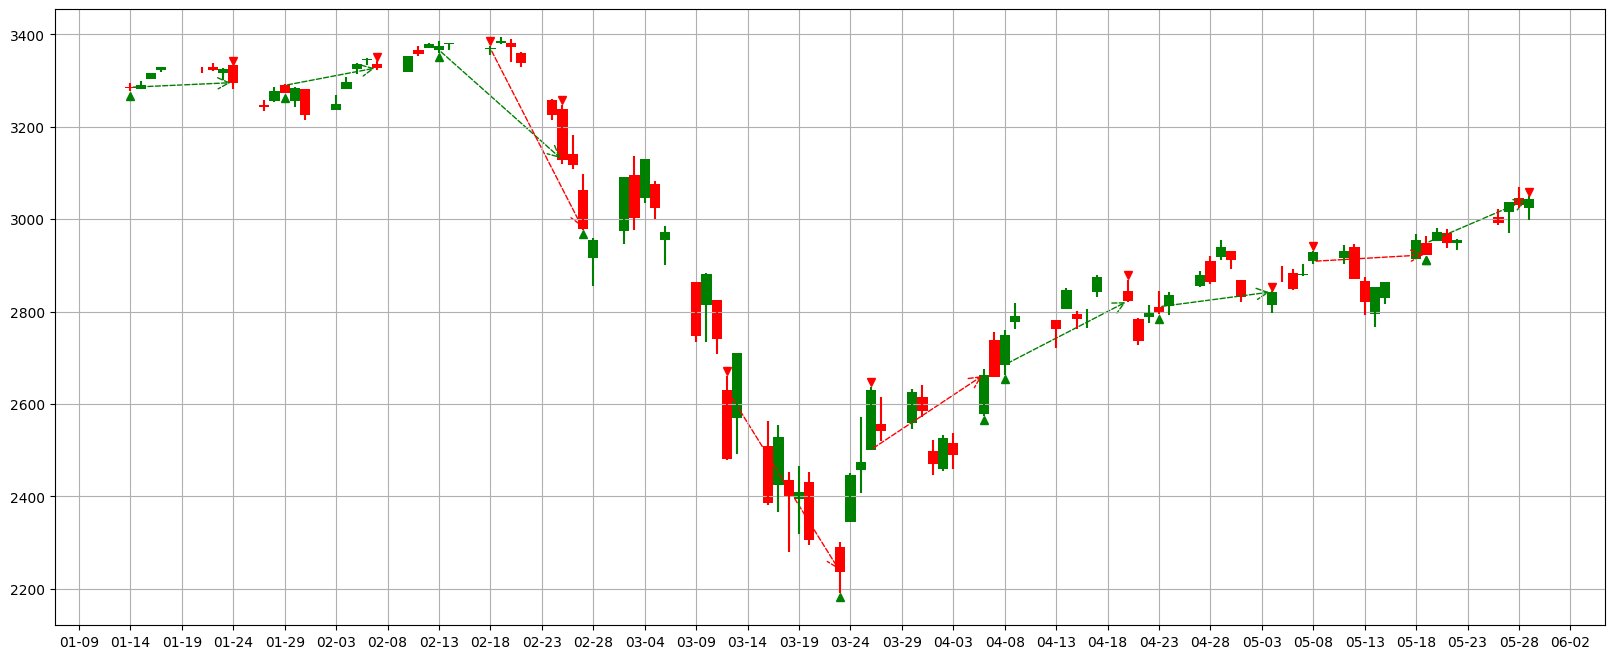

In [49]:
draw_profit_plot(profit_table, pv_range)

In [50]:
total_profit, profit_table = build_profit_table_method_2(result_table, profit_percentage, loss_percentage)
print('total_profit =', total_profit)
with pd.option_context('display.max_rows', None,
                    'display.max_columns', None,
                    'display.precision', 3,
                    ):
    print(profit_table)

total_profit = 553.7461669921872
           in_date in_price    out_date out_price      pv   profit  \
data_0  2020-01-14  3285.35  2020-01-24   3295.47  valley    10.12   
data_1  2020-01-29  3289.46  2020-02-07   3327.71  valley    38.25   
data_2  2020-02-13   3365.9  2020-02-25   3128.21  valley  -237.69   
data_3  2020-02-18  3369.04  2020-02-27   2978.76    peak   390.28   
data_4  2020-03-12  2630.86  2020-03-17  2367.774    peak  263.086   
data_5  2020-03-26  2501.29  2020-04-06   2663.68    peak  -162.39   
data_6  2020-04-08   2685.0  2020-04-20   2823.16  valley   138.16   
data_7  2020-04-23  2810.42  2020-05-04   2842.74  valley    32.32   
data_8  2020-05-08  2908.83  2020-05-19   2922.94    peak   -14.11   
data_9  2020-05-19  2948.59  2020-05-29   3044.31  valley    95.72   

           strategy strategy_price  
data_0          NaN            NaN  
data_1          NaN            NaN  
data_2          NaN            NaN  
data_3          NaN            NaN  
data_4  sto

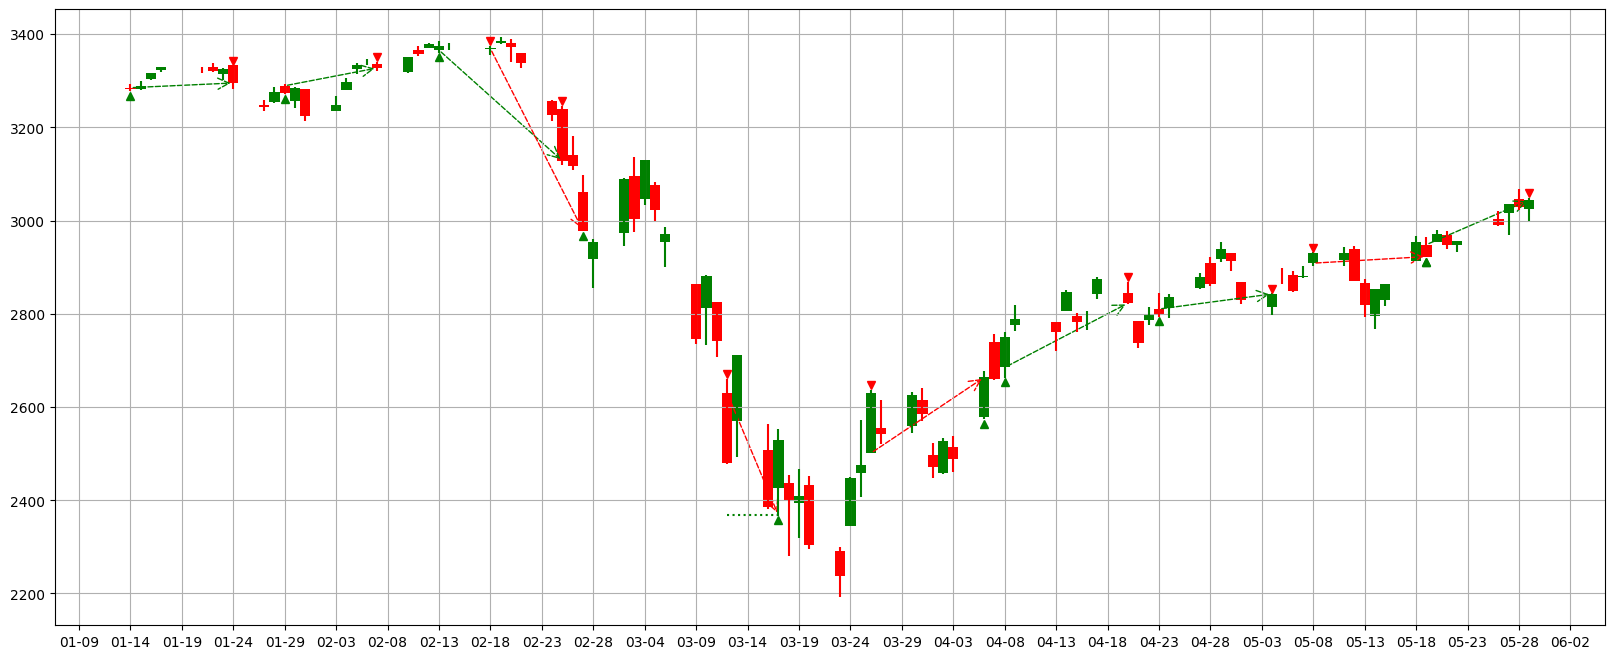

In [51]:
draw_profit_plot(profit_table, pv_range)

In [52]:
total_profit, profit_table = build_profit_table_method_3(result_table, profit_percentage, loss_percentage)
print('total_profit =', total_profit)
with pd.option_context('display.max_rows', None,
                    'display.max_columns', None,
                    'display.precision', 3,
                    ):
    print(profit_table)

total_profit = 481.6022460937497
           in_date in_price    out_date out_price      pv   profit  \
data_0  2020-01-14  3285.35  2020-01-24   3295.47  valley    10.12   
data_1  2020-01-29  3289.46  2020-02-07   3327.71  valley    38.25   
data_2  2020-02-13   3365.9  2020-02-25   3128.21  valley  -237.69   
data_3  2020-02-18  3369.04  2020-02-27   2978.76    peak   390.28   
data_4  2020-03-12  2630.86  2020-03-16  2439.918    peak  190.942   
data_5  2020-03-26  2501.29  2020-04-06   2663.68    peak  -162.39   
data_6  2020-04-08   2685.0  2020-04-20   2823.16  valley   138.16   
data_7  2020-04-23  2810.42  2020-05-04   2842.74  valley    32.32   
data_8  2020-05-08  2908.83  2020-05-19   2922.94    peak   -14.11   
data_9  2020-05-19  2948.59  2020-05-29   3044.31  valley    95.72   

           strategy strategy_price  
data_0          NaN            NaN  
data_1          NaN            NaN  
data_2          NaN            NaN  
data_3          NaN            NaN  
data_4  sto

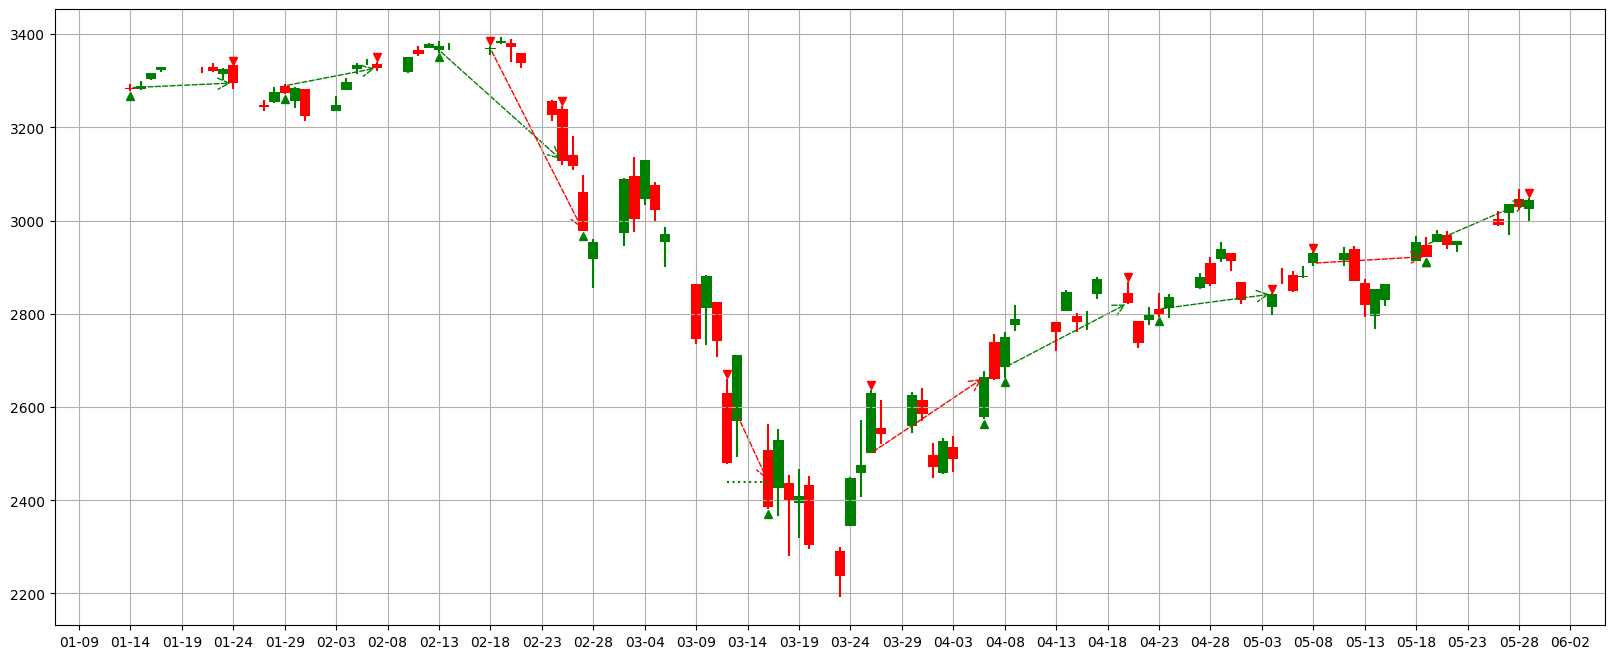

In [53]:
draw_profit_plot(profit_table, pv_range)